# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam
from liesel_gam.builder.consolidate_bases import consolidate_bases, evaluate_bases

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

,x,y,eta,z
0,0.000000,0.0,1.162528e-19,0.103675
1,0.014286,0.0,1.344590e-01,0.380944
2,0.028571,0.0,2.678353e-01,0.366966
3,0.042857,0.0,3.990553e-01,0.008108
4,0.057143,0.0,5.270622e-01,0.798669
...,...,...,...,...
5036,0.942857,1.0,1.281348e+00,1.076909
5037,0.957143,1.0,1.164770e+00,1.171729
5038,0.971429,1.0,1.044978e+00,1.027468
5039,0.985714,1.0,9.230304e-01,0.818835


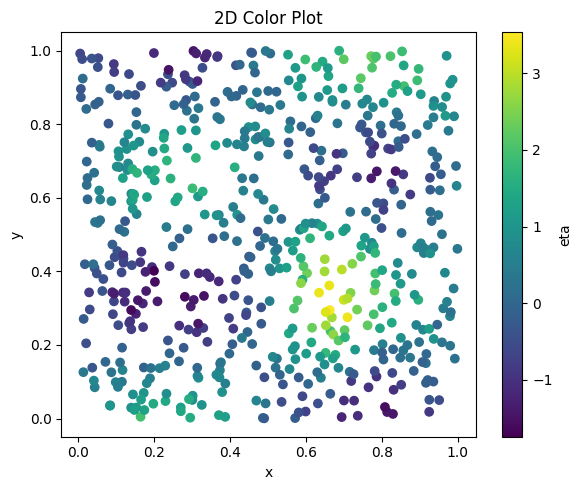

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

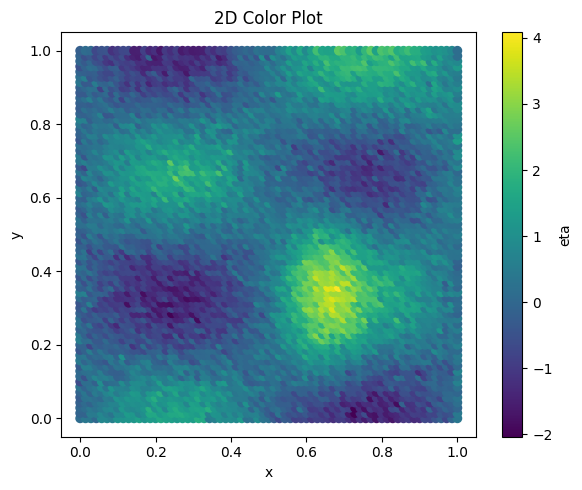

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

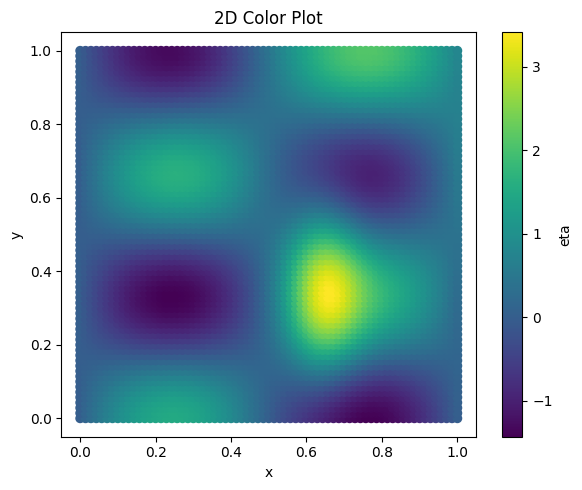

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [9]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [10]:
tb = gam.TermBuilder.from_df(df)

In [11]:
loc += (
    tb.ti(
        "x",
        "y",
        k=10,
        scale=gam.ScaleIG(1.0, 1.0, 0.0005),
    ),
    tb.ps("x", k=20),
    tb.ps("y", k=20),
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


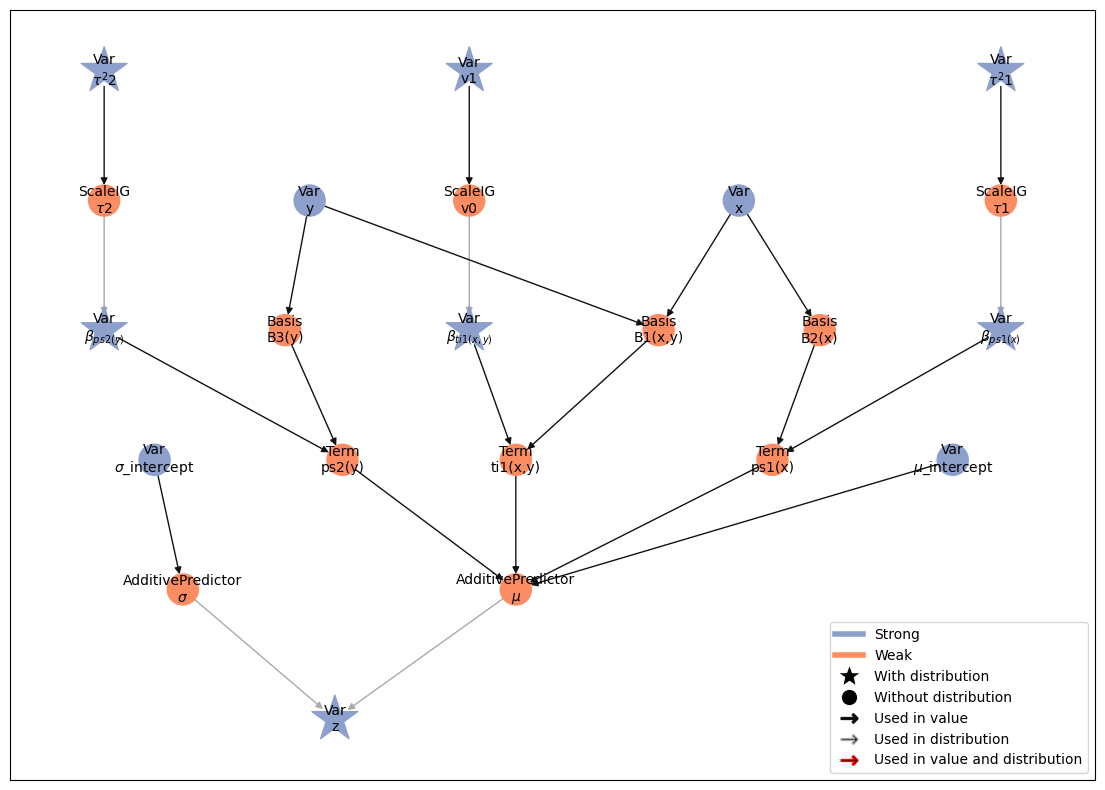

In [12]:
model = lsl.Model([z])
model.plot_vars()

In [13]:
model, bases_model = consolidate_bases(model)

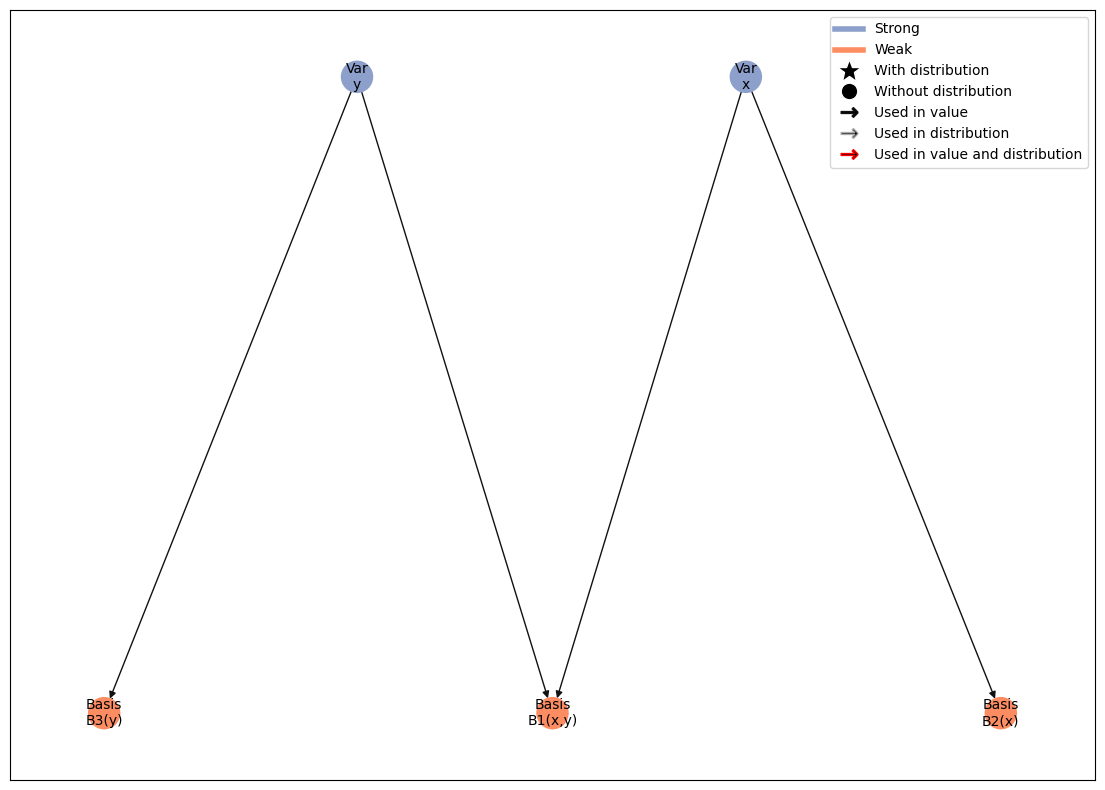

In [14]:
bases_model.plot_vars()

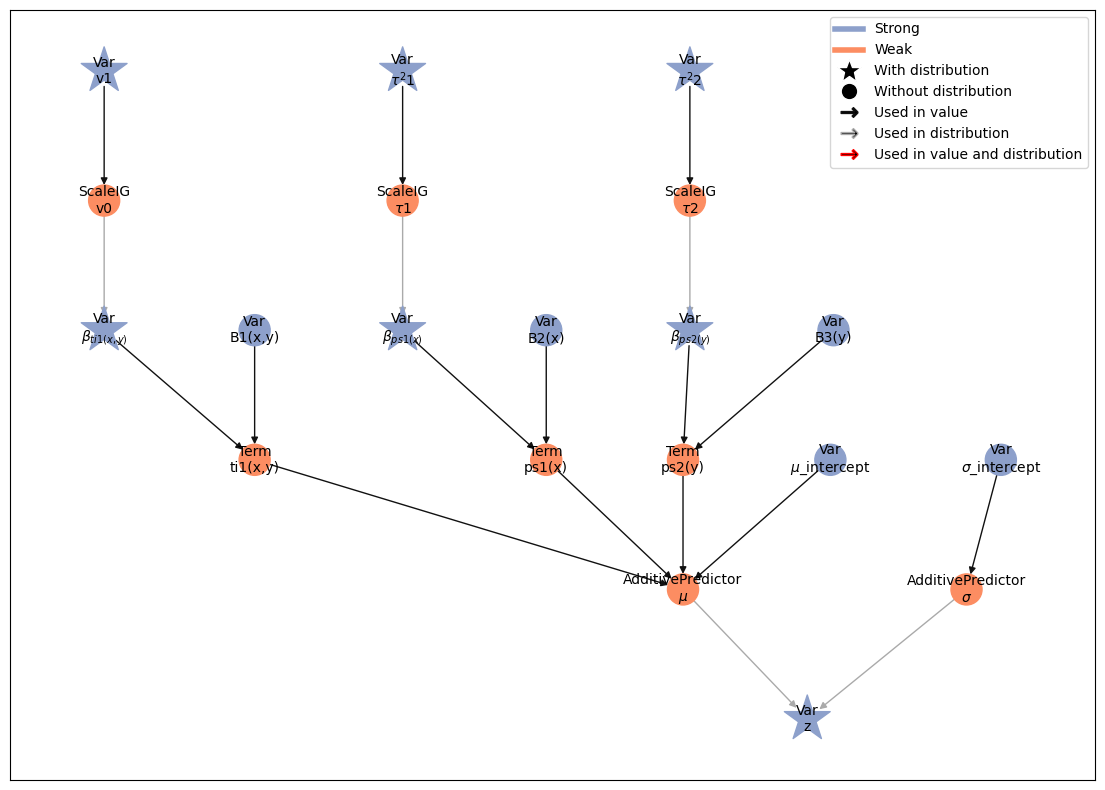

In [15]:
model.plot_vars()

In [16]:
import optax

params = [p.name for p in model.parameters.values() if not p.name.startswith("$\\tau")]
opt = gs.optim_flat(
    model, params, optimizer=optax.adam(learning_rate=1e-5), progress_bar=False
)

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [17]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'v1', '$\\beta_{ti1(x,y)}$', '$\\tau^2$1', '$\\beta_{ps1(x)}$', '$\\tau^2$2', '$\\beta_{ps2(y)}$', '$\\mu$_intercept', '$\\sigma$_intercept'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:05<00:00,  1.35chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 701.74chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1100.15chunk/s]
liesel.goose.eng

### MCMC summary

In [18]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   kernel_03 -0.017991  0.080053 -0.146360 -0.016090   
                   (1,)   kernel_03 -0.001763  0.076467 -0.124818  0.002005   
                   (2,)   kernel_03 -0.004395  0.072626 -0.122772 -0.003008   
                   (3,)   kernel_03  0.038922  0.077677 -0.077033  0.034807   
                   (4,)   kernel_03 -0.026347  0.074676 -0.146808 -0.022633   
...                             ...       ...       ...       ...       ...   
$\mu$_intercept    ()     kernel_06  0.338993  0.011529  0.319774  0.338959   
$\sigma$_intercept ()     kernel_07 -1.343811  0.032868 -1.399010 -1.342567   
$\tau^2$1          ()     kernel_02  0.006386  0.003264  0.002848  0.005479   
$\tau^2$2          ()     kernel_04  0.002149  0.001503  0.000782  0.001734   
v1                 ()     kernel_00  0.105940  0.018059  0.079617  0.104314   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{ps1(x)}$   (0,)   0.106233          800  422.021052  557.579816   
                   (1,)   0.115548          800  422.143808  530.248214   
                   (2,)   0.115680          800  446.030686  397.562265   
                   (3,)   0.174919          800  328.845095  487.340306   
                   (4,)   0.093914          800  332.202968  607.107223   
...                            ...          ...         ...         ...   
$\mu$_intercept    ()     0.358927          800  575.556832  564.732530   
$\sigma$_intercept ()    -1.290492          800  686.245219  697.537607   
$\tau^2$1          ()     0.012551          800  284.890157  581.100357   
$\tau^2$2          ()     0.004903          800  142.614257  302.816765   
v1                 ()     0.139024          800  572.670344  743.124412   

                              rhat  
parameter          index            
$\beta_{ps1(x)}$   (0,)   1.008344  
                   (1,)   1.001881  
                   (2,)   1.011817  
                   (3,)   0.999870  
                   (4,)   1.008638  
...                            ...  
$\mu$_intercept    ()     1.000838  
$\sigma$_intercept ()     1.001908  
$\tau^2$1          ()     1.006438  
$\tau^2$2          ()     1.032085  
v1                 ()     1.000354  

[124 rows x 10 columns]

## Predictions

In [20]:
samples = results.get_posterior_samples()

In [21]:
newdata = {"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()}
newdata = evaluate_bases(newdata, bases_model)

### Predict variables at new x values

In [22]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["ti1(x,y)", "$\\mu$", "ps1(x)", "ps2(y)"],
    newdata=newdata,
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [23]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [24]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x,y
0,$\mu$,$\mu$[0],"(0,)",800,0.229282,0.231917,0.481577,230.960410,462.383223,0.031742,0.014506,1.014864,-0.543051,0.228338,1.029150,-0.549440,1.003208,0.000000,0.0
1,$\mu$,$\mu$[1],"(1,)",800,-0.128193,0.217338,0.466195,144.303428,325.307424,0.038203,0.020757,1.027517,-0.886046,-0.123639,0.614907,-0.883421,0.617686,0.014286,0.0
2,$\mu$,$\mu$[2],"(2,)",800,-0.316409,0.333441,0.577444,116.728337,242.490493,0.052808,0.026916,1.024695,-1.323124,-0.305278,0.592141,-1.340620,0.579648,0.028571,0.0
3,$\mu$,$\mu$[3],"(3,)",800,-0.353569,0.434203,0.658941,116.420187,227.687330,0.060348,0.030101,1.021523,-1.471896,-0.353089,0.707033,-1.496881,0.678827,0.042857,0.0
4,$\mu$,$\mu$[4],"(4,)",800,-0.267219,0.460771,0.678801,117.815714,265.199249,0.061781,0.030491,1.019881,-1.409126,-0.271695,0.822387,-1.402725,0.828944,0.057143,0.0


### Plot fitted functions

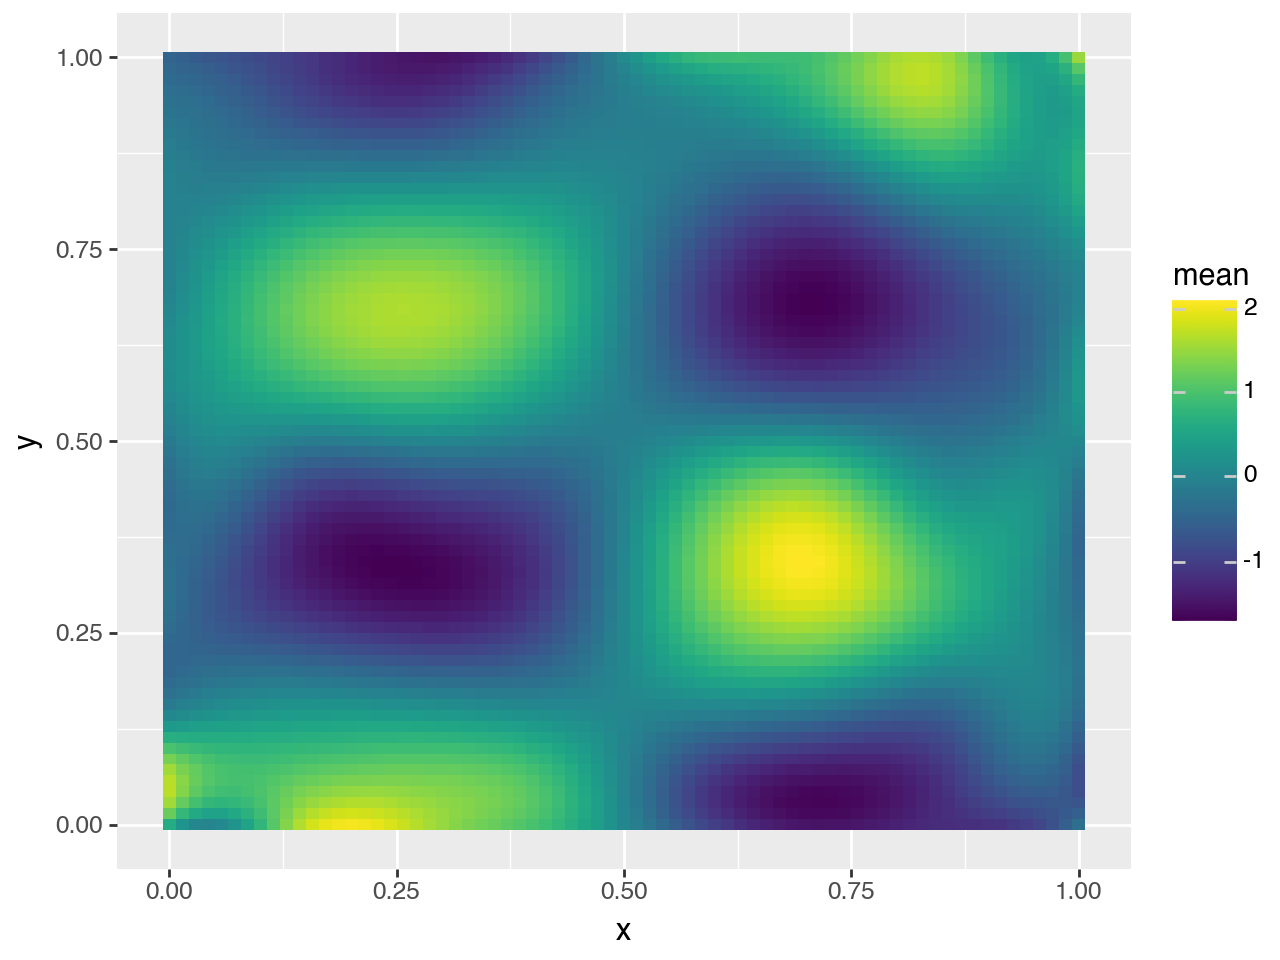

In [25]:
select = predictions_summary["variable"].isin(["ti1(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

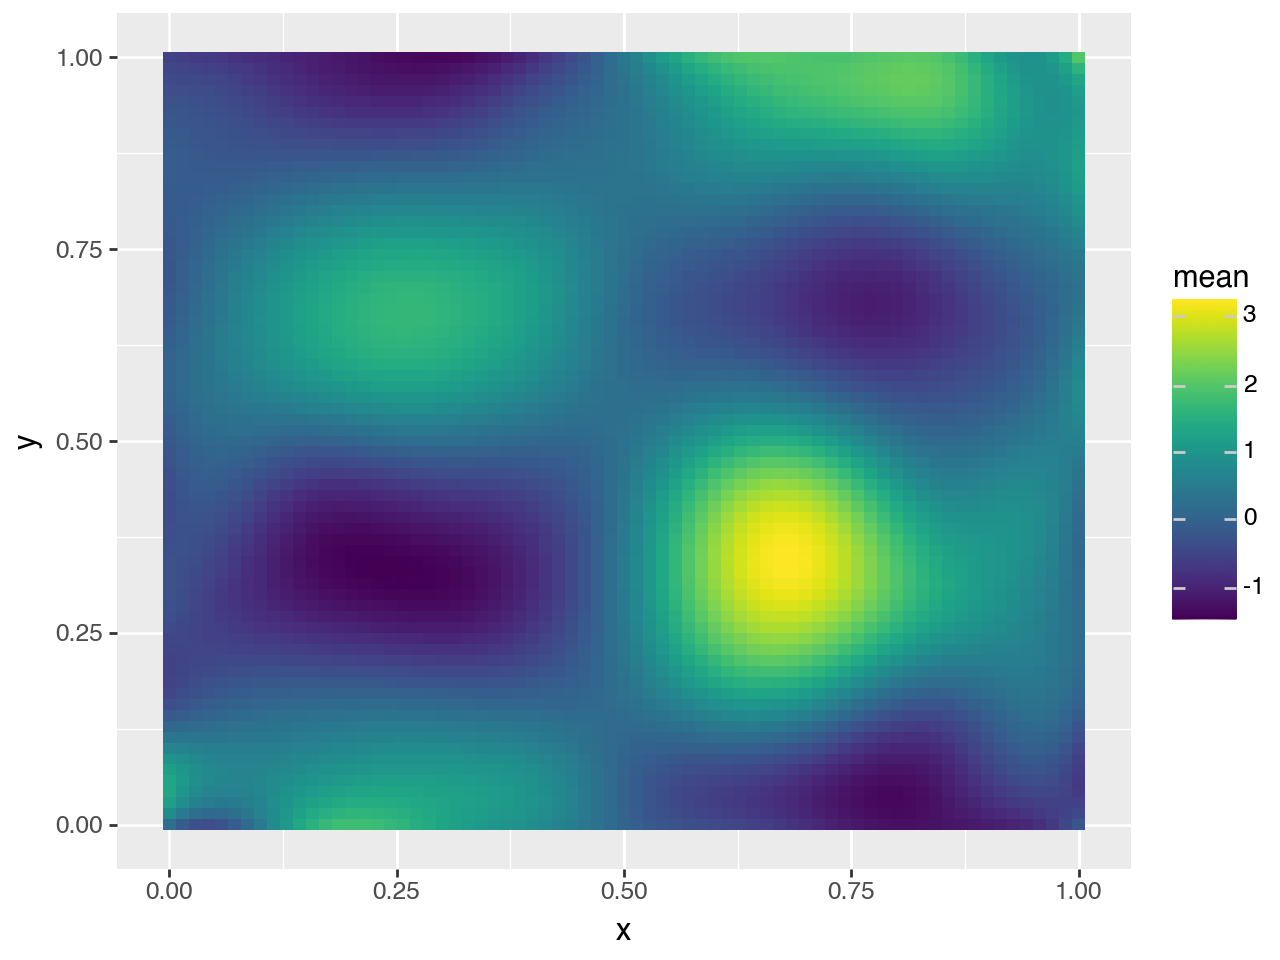

In [26]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

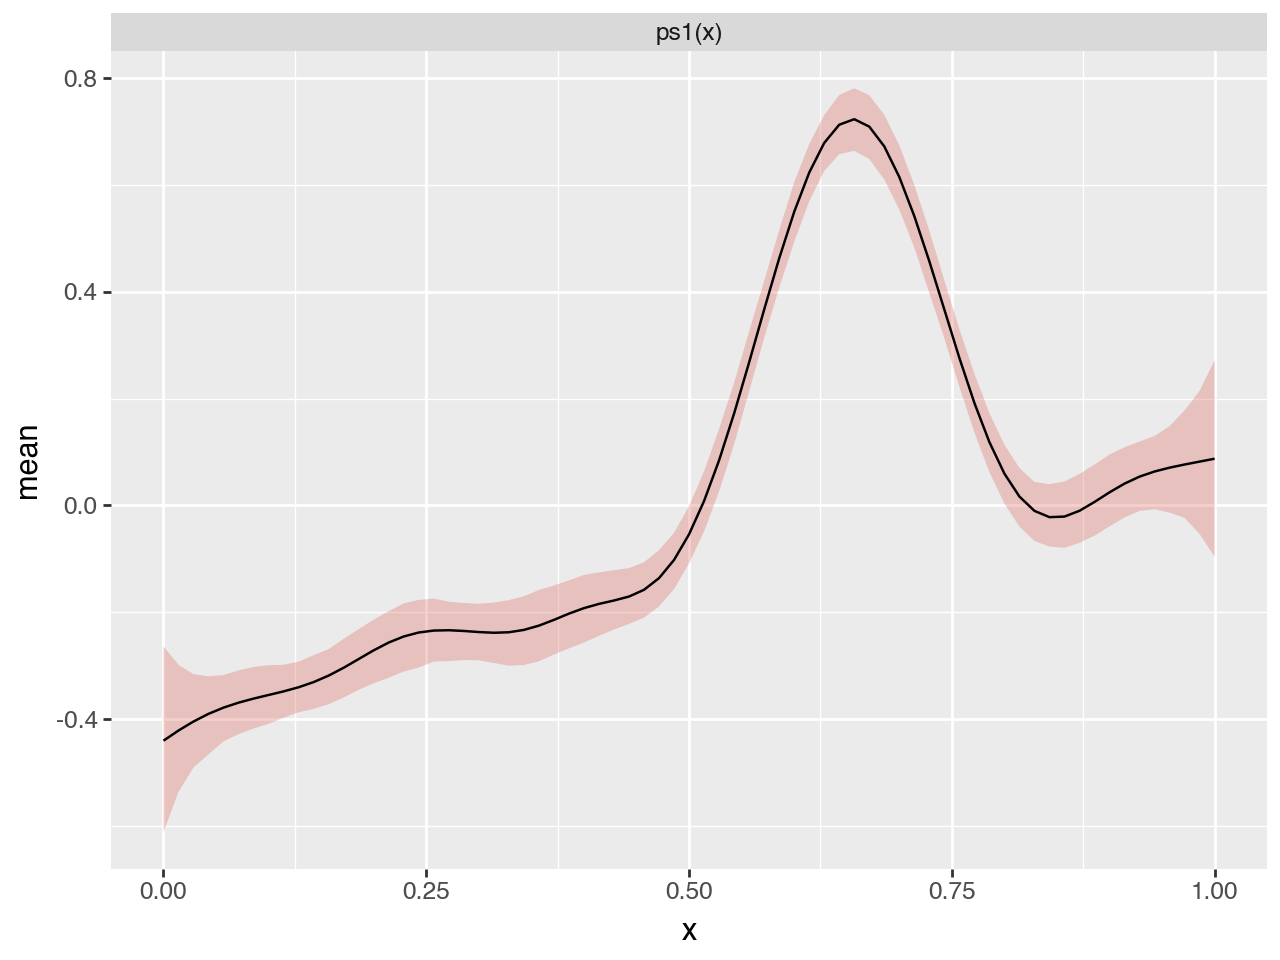

In [27]:
select = predictions_summary["variable"].isin(["ps1(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

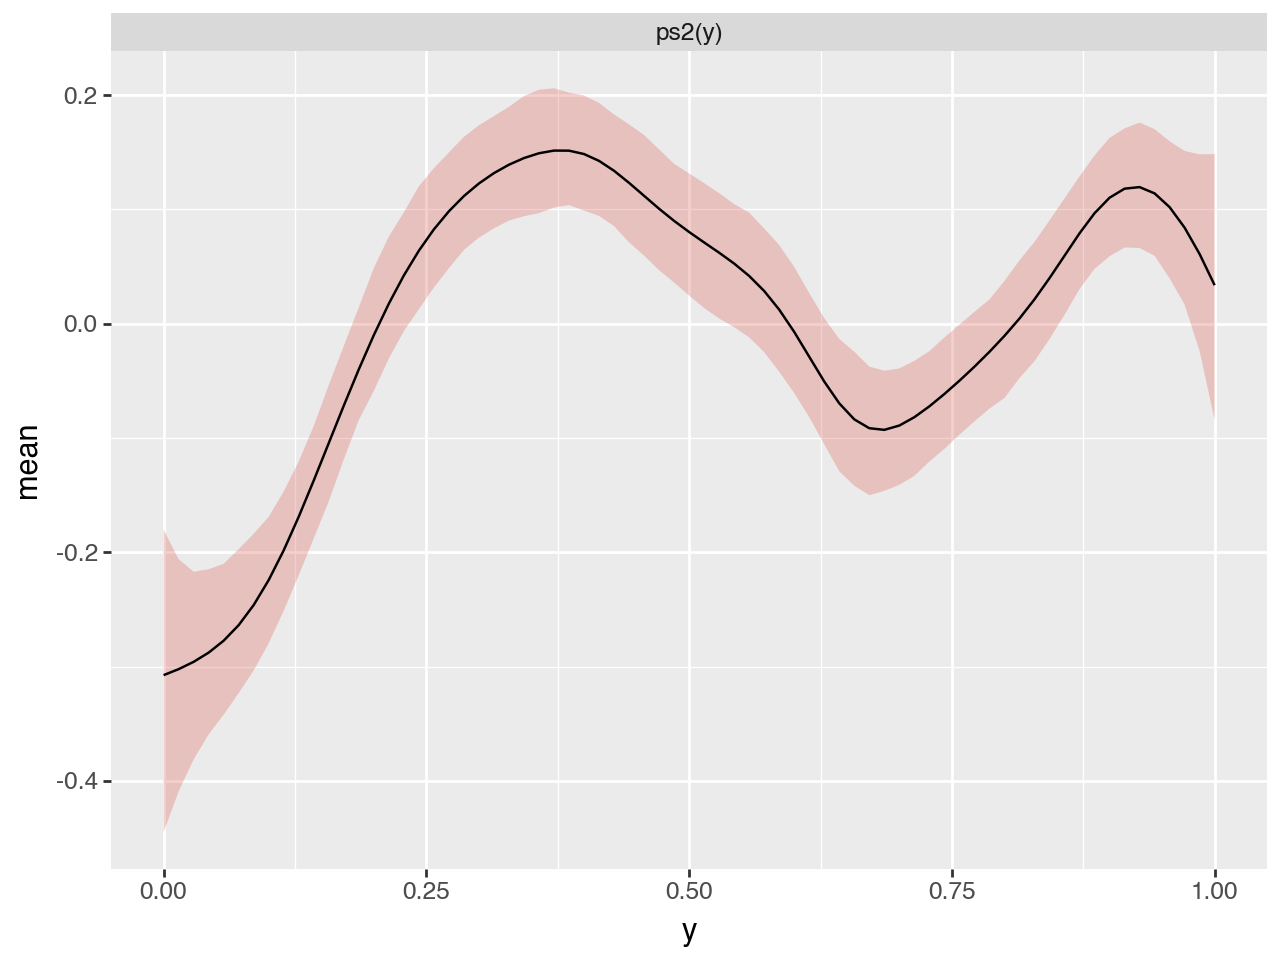

In [28]:
select = predictions_summary["variable"].isin(["ps2(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)